Modules:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
from matplotlib.ticker import MaxNLocator

Data cleaning and preparation:

In [3]:
##### Import data ##### 
### Monthly SP500TR ###
# Read CSV file for SP500TR
SP500TR = pd.read_csv('SP500TR.csv')

# Remove the first two rows and keep only the first two columns 
SP500TR = SP500TR.iloc[2:, :2]

# Rename columns
SP500TR.columns = ["Date", "SP500TR"]

# Set Date as index
SP500TR.set_index("Date", inplace=True)

# Convert index to datetime 
SP500TR.index = pd.to_datetime(SP500TR.index)

# Fix issue with SP500TR not being numeric
SP500TR["SP500TR"] = pd.to_numeric(SP500TR["SP500TR"], errors='coerce')

### Monthly SPBDUB3T ###
SPBDUB3T = pd.read_excel('SPBDUB3T.xlsx', index_col=0)

# Convert index to datetime 
SPBDUB3T.index = pd.to_datetime(SPBDUB3T.index)

# Change index to first of month
SPBDUB3T.index = SPBDUB3T.index.to_period('M').to_timestamp()

### Monthly PCE ###
PCE =  pd.read_csv('PCE.csv', index_col=0)

# Convert index to datetime 
PCE.index = pd.to_datetime(PCE.index)

### Monthly PCEPI ###
PCEPI =  pd.read_csv('PCEPI.csv', index_col=0)

# Convert index to datetime 
PCEPI.index = pd.to_datetime(PCEPI.index)

##### Join DataFrames #####
# Join on the dates of SPBDUB3T
df = SPBDUB3T.join([SP500TR, PCE, PCEPI], how='left')

# Define start and end dates 
start_date, end_date = '1989-12-01', '2024-12-01'

# Slice the DataFrame between the two dates
df = df.loc[start_date:end_date]

### Monthly Data ###
df_monthly = df.copy()

# Calculate monthly return and changes for SP500TR, SPBDUB3T, PCE, PCEPI and EP
df_monthly["RET_SPBDUB3T"] = (df_monthly["SPBDUB3T"] / df_monthly["SPBDUB3T"].shift(1) - 1)
df_monthly["RET_SP500TR"] = (df_monthly["SP500TR"] / df_monthly["SP500TR"].shift(1) - 1)
df_monthly["CHG_PCE"] = (df_monthly["PCE"] / df_monthly["PCE"].shift(1) - 1)
df_monthly["CHG_PCEPI"] = (df_monthly["PCEPI"] / df_monthly["PCEPI"].shift(1) - 1)
df_monthly["N_RET_EP"] = df_monthly["RET_SP500TR"] - df_monthly["RET_SPBDUB3T"]


# Calculate monthly real return and changes for SP500TR, SPBDUB3T, PCE, PCEPI and EP
df_monthly["R_RET_SPBDUB3T"] = ((1+df_monthly["RET_SPBDUB3T"])/(1+df_monthly["CHG_PCEPI"]) - 1)
df_monthly["R_RET_SP500TR"] = ((1+df_monthly["RET_SP500TR"])/(1+df_monthly["CHG_PCEPI"]) - 1)
df_monthly["R_CHG_PCE"] = ((1+df_monthly["CHG_PCE"])/(1+df_monthly["CHG_PCEPI"]) - 1)
df_monthly["R_RET_EP"] = df_monthly["R_RET_SP500TR"] - df_monthly["R_RET_SPBDUB3T"]

### Yearly Data ###
df_yearly = df.copy()

# Filter for December
df_yearly = df_yearly[df_yearly.index.month == 12]

# Calculate yearly return and changes for SP500TR, SPBDUB3T, PCE, PCEPI and EP
df_yearly["RET_SPBDUB3T"] = (df_yearly["SPBDUB3T"] / df_yearly["SPBDUB3T"].shift(1) - 1)
df_yearly["RET_SP500TR"] = (df_yearly["SP500TR"] / df_yearly["SP500TR"].shift(1) - 1)
df_yearly["CHG_PCE"] = (df_yearly["PCE"] / df_yearly["PCE"].shift(1) - 1)
df_yearly["CHG_PCEPI"] = (df_yearly["PCEPI"] / df_yearly["PCEPI"].shift(1) - 1)
df_yearly["N_RET_EP"] = df_yearly["RET_SP500TR"] - df_yearly["RET_SPBDUB3T"]

# Calculate yearly real return and changes for SP500TR, SPBDUB3T, PCE, PCEPI and EP
df_yearly["R_RET_SPBDUB3T"] = ((1+df_yearly["RET_SPBDUB3T"])/(1+df_yearly["CHG_PCEPI"]) - 1)
df_yearly["R_RET_SP500TR"] = ((1+df_yearly["RET_SP500TR"])/(1+df_yearly["CHG_PCEPI"]) - 1)
df_yearly["R_CHG_PCE"] = ((1+df_yearly["CHG_PCE"])/(1+df_yearly["CHG_PCEPI"]) - 1)
df_yearly["R_RET_EP"] = df_yearly["R_RET_SP500TR"] - df_yearly["R_RET_SPBDUB3T"]

Data exploration and visualization:

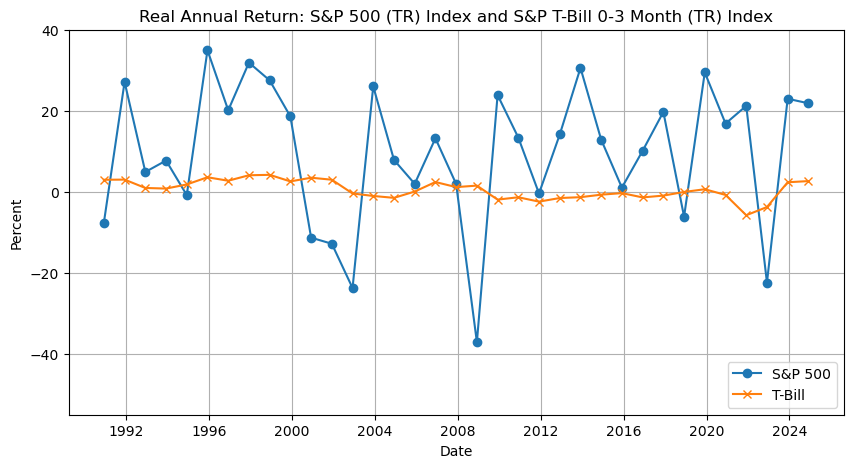

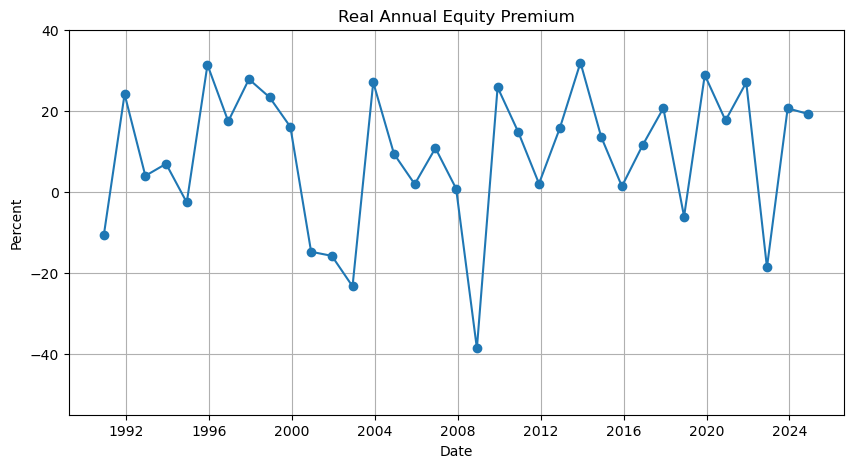

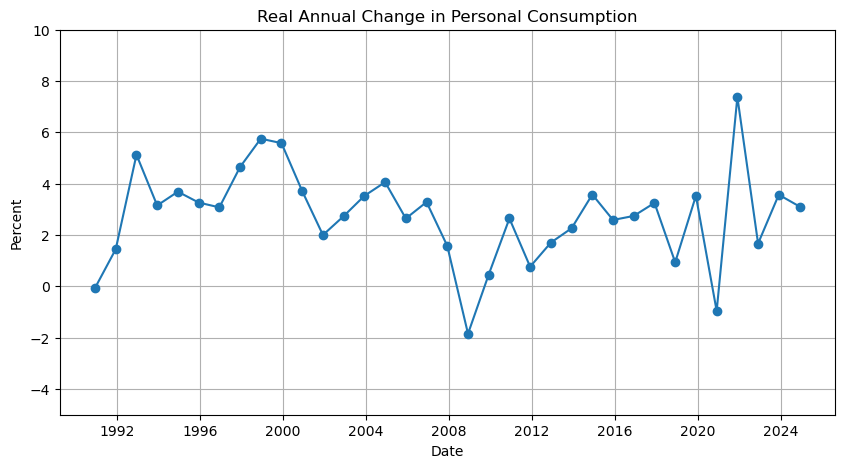

In [4]:
# Real Market Return and Yield
plt.figure(figsize=(10, 5))
plt.plot(df_yearly.index, df_yearly['R_RET_SP500TR']*100, marker='o', label="S&P 500")
plt.plot(df_yearly.index, df_yearly["R_RET_SPBDUB3T"]*100, marker='x', label="T-Bill")
plt.xlabel('Date')
plt.ylabel('Percent')
plt.title('Real Annual Return: S&P 500 (TR) Index and S&P T-Bill 0-3 Month (TR) Index')
plt.legend(loc="lower right")
plt.ylim(-55, 40)
plt.grid()
plt.show()

# Real Equity Premium
plt.figure(figsize=(10, 5))
plt.plot(df_yearly.index, df_yearly["R_RET_EP"]*100, marker='o')
plt.xlabel('Date')
plt.ylabel('Percent')
plt.title('Real Annual Equity Premium')
plt.ylim(-55, 40)
plt.grid()
plt.show()

# Real Growth Rate of Consumption
plt.figure(figsize=(10, 5))
plt.plot(df_yearly.index, df_yearly['R_CHG_PCE']*100, marker='o')
plt.xlabel('Date')
plt.ylabel('Percent')
plt.title('Real Annual Change in Personal Consumption')
plt.ylim(-5, 10)
plt.grid()
plt.show()

Mehra and Prescott (2003):

In [5]:
### Set the variables of the model ###

# Mean and variance of real consumption growth (from simple returns)
E_x = (1 + df_yearly["R_CHG_PCE"]).mean()           # Convert to gross return
var_x = df_yearly["R_CHG_PCE"].var()                # Variance of simple returns

# Convert to log mean and log variance
sigma_x2 = np.log(1 + var_x / E_x**2)               # log-variance of consumption growth
mu_x = np.log(E_x) - 0.5 * sigma_x2                 # log-mean of consumption growth

### Set beta and alpha ###
alpha = 10
beta = 0.99

### Expected real return on equity and risk-free asset ###
E_Rf = -np.log(beta) + alpha * mu_x - 0.5 * (alpha**2) * sigma_x2
E_Re = E_Rf + alpha * sigma_x2
E_Rp = E_Re - E_Rf

# Print results
print(f"Real expected return on equity is {np.round(E_Re * 100, 5)}%")
print(f"Real expected return on risk-free asset is {np.round(E_Rf * 100, 5)}%")
print(f"Equity risk-premium is given by {np.round(E_Rp * 100, 5)}%")


Real expected return on equity is 26.78372%
Real expected return on risk-free asset is 26.45943%
Equity risk-premium is given by 0.32429%


In [7]:
### Prescott and Mehra (2003) ###

# Mean real consumption growth rate (gross)
E_x_mp = 1.018

# Standard deviation of real consumption growth rate (in levels)
sigma_x_level = 0.036
var_x = sigma_x_level**2

# Compute log-variance of consumption growth rate
sigma2_x_mp = np.log(1 + var_x / E_x_mp**2)

# Compute log-mean of consumption growth
mu_x_mp = np.log(E_x_mp) - 0.5 * sigma2_x_mp

### Set beta and alpha ###
alpha_mp = 10
beta_mp = 0.99

### Expected real return on equity and risk-free asset ###

# Real risk-free return (continuously compounded)
E_Rf_mp = -np.log(beta_mp) + alpha_mp * mu_x_mp - 0.5 * (alpha_mp**2) * sigma2_x_mp

# Real equity return
E_Re_mp = E_Rf_mp + alpha_mp * sigma2_x_mp

# Equity risk premium
E_Rp_mp = E_Re_mp - E_Rf_mp

# Print results
print(f"Real expected return on equity: {np.round(E_Re_mp * 100, 5)}%")
print(f"Real expected return on risk-free asset: {np.round(E_Rf_mp * 100, 5)}%")
print(f"Equity risk premium: {np.round(E_Rp_mp * 100, 5)}%")


Real expected return on equity: 13.22088%
Real expected return on risk-free asset: 11.97109%
Equity risk premium: 1.24979%


In [8]:
### Magnitude of equity premium puzzle ###
magnitude = E_Rp_mp/E_Rp

print(f"As the model is linear in its parameters one can easily conclude that the equity premium puzzle has increased by a magnitude of {np.round(magnitude,5)}.")

As the model is linear in its parameters one can easily conclude that the equity premium puzzle has increased by a magnitude of 3.8539.


Benartzi and Thaler (1995):

In [ ]:
# Define block bootstrap function
def block_bootstrap(x, block_length=12, n_samples=100000):
    n = len(x)
    returns = []

    for _ in range(n_samples):
        last_start = n - block_length
        start = np.random.randint(0, last_start + 1)  # +1 because upper bound is exclusive
        block = x[start:start + block_length]
        block_return = np.prod(1 + block) - 1
        returns.append(block_return)

    return np.array(returns)

# Initialize storage dictionaries
bond_data = {}
stock_data = {}

# Generate bootstrapped samples for block lengths 1 to 18
for i in range(1, 19):
    bond_data[i] = block_bootstrap(df_monthly["RET_SPBDUB3T"], block_length=i, n_samples=100000)
    stock_data[i] = block_bootstrap(df_monthly["RET_SP500TR"], block_length=i, n_samples=100000)

# Convert to DataFrames
bond_df = pd.DataFrame(bond_data)
stock_df = pd.DataFrame(stock_data)

# Save to CSV
bond_df.to_csv("bond_data.csv", index=False)
stock_df.to_csv("stock_data.csv", index=False)

KeyboardInterrupt: 

In [138]:
# Parameters
alpha = 0.88
beta = 0.88
lam = 2.25
gamma_gain = 0.61
gamma_loss = 0.68

# Define value function
def value_function(x, alpha, beta, lam):
    if x >= 0:
        return x**alpha
    else:
        return -lam * ((-x)**beta)
    
# Define weighting function
def weighting_function(p, gamma):
    if p == 0: 
        return 0
    elif p == 1:
        return 1
    else: 
        return (p**gamma)/((p**gamma + (1 - p)**gamma)**(1/gamma))

def cpt_utility(x):
    # Sort values ascending
    x = np.sort(x)

    # Find length of data
    n = len(x)

    # Seperate into gains and losses
    x_gain = x[(x >= 0)]
    x_loss = x[(x < 0)]

    ### Gains ###
    if len(x_gain) > 0:
        # CDF for gains
        ECDF_gain = ECDF(x_gain)

        # Unique values for the gains
        unique_gain = np.unique(x_gain)

        # CCDF = 1 - ECDF(x) + P(X = x)
        unique_probs_gain = (1 - ECDF_gain(unique_gain) + np.array([np.sum(x_gain == x) / len(x_gain) for x in unique_gain])) * (len(x_gain)/n)

        ### Prospect utility for gains ###
        # Add zero to the end of probabilities
        unique_probs_gain_with_zero = np.append(unique_probs_gain, 0)

        # Initialize utility
        utility_gain = 0

        for i in range(len(unique_gain)):
            utility_gain += value_function(unique_gain[i], alpha, beta, lam) \
                * (weighting_function(unique_probs_gain_with_zero[i], gamma=gamma_gain) \
                    - weighting_function(unique_probs_gain_with_zero[i+1], gamma=gamma_gain))

    else:
        utility_gain = 0

    if len(x_loss) > 0: 
    ### Losses ###
    # CDF for losses
        ECDF_loss = ECDF(x_loss)

        # Unique valus for the losses
        unique_loss = np.unique(x_loss)

        # Get ECDF probabilities at the unique values
        unique_probs_loss = ECDF_loss(unique_loss) * (len(x_loss)/n)

        ### Prospect utility for losses ###
        # Sort descending and add zero at the end of probabilities
        unique_loss_desc = unique_loss[::-1]
        unique_probs_loss_desc_with_zero = np.append(unique_probs_loss[::-1], 0)

        # Initialize utility
        utility_loss = 0

        for i in range(len(unique_loss_desc)):
            utility_loss += value_function(unique_loss_desc[i], alpha, beta, lam) \
                * (weighting_function(unique_probs_loss_desc_with_zero[i], gamma=gamma_loss) \
                    - weighting_function(unique_probs_loss_desc_with_zero[i+1], gamma=gamma_loss))

    else:
        utility_loss = 0
        
    ### Sum of utilities ###
    utility = utility_loss + utility_gain

    return utility


In [ ]:
def sim_utility(x, max_block_length=19, n_samples=100000):
    ### Loop for determining prospect utility ###
    # Save results
    months =[]
    utility = []

    for i in range(1, max_block_length):
        # Block bootstrap for block length i
        data = block_bootstrap(x, block_length=i, n_samples=n_samples)
        
        # CPT utility
        cpt = cpt_utility(data)
        
        # Append results
        months.append(i)
        utility.append(cpt)

    return months, utility

def sim_utility_fixed_block_length(x, block_length=12, n_samples=100000):    
    # Block bootstrap
    data = block_bootstrap(x, block_length=block_length, n_samples=n_samples)

    # CPT utility
    utility = cpt_utility(data)
    
    return utility

In [ ]:
# Simulation for T-Bills
months, utility_tbill = sim_utility(df_monthly["RET_SPBDUB3T"][1:], max_block_length=19, n_samples=10000)

# Simulation for SP500TR
months, utility_SP500TR = sim_utility(df_monthly["RET_SP500TR"][1:], max_block_length=19, n_samples=10000)

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(months, utility_tbill, marker='o', color="red")
plt.plot(months, utility_SP500TR, marker='o', color="blue")
plt.xlabel('Month')
plt.ylabel('Prospect Utility')
plt.title('Prospect Utility from Stocks and Bonds')
plt.ylim(-0.04, 0.10)
plt.xlim(0, 19)
plt.grid()

# Force whole number ticks on x-axis
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

Wait!

In [ ]:
# Ensure returns are NumPy arrays
RET_SP500TR = df_monthly["RET_SP500TR"].iloc[1:].values
RET_SPBDUB3T = df_monthly["RET_SPBDUB3T"].iloc[1:].values

# Number of portfolios
n = 21 

# Create n weights from 0 to 1
weights = np.linspace(0, 1, n)

# Matrix to hold time series of portfolio returns
RET_PORT = np.zeros((len(RET_SP500TR), n))

# Compute portfolio returns for each weight
for i, w in enumerate(weights):
    RET_PORT[:, i] = w * RET_SP500TR + (1 - w) * RET_SPBDUB3T

# Wrap in DataFrame
RET_PORT_df = pd.DataFrame(RET_PORT, columns=[f'{w:.2f}' for w in weights])

# Utility of portfolio 
utility_port = np.zeros(n)

for i in range(n):
    utility_port[i] = sim_utility_fixed_block_length(RET_PORT_df.iloc[:, i], 12, n_samples=10000)

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(weights*100, utility_port, marker='o', color="red")
plt.xlabel('Percent Invested in Stock')
plt.ylabel('Prospect Utility')
plt.title('Prospect Utility for Portfolio of Stocks and T-Bills')
plt.ylim(0, 0.06)
plt.grid()

# Force whole number ticks on x-axis
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))